## Federal Reserve Economic Rate:  Civilian Unemployment Rate

1. [Install Libraires and Data](#lib)

2. [Checking the Data](#check)

3. [Data Wrangling, Subsetting, Cleaning: Time Series Analysis](#clean)

4. [Test for Stationarity](#test)

5. [Stationarizing: Federal Reserve Economic Data](#fed)

In [36]:
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm # Using .api imports the public access version of statsmodels, which is a library that handles 
# statistical models.
import os
import warnings # This is a library that handles warnings.

warnings.filterwarnings("ignore") # Disable deprecation warnings that could indicate, for instance, a suspended library or 
# feature. These are more relevant to developers and very seldom to analysts.

plt.style.use('fivethirtyeight') # This is a styling option for how your plots will appear. More examples here:
# https://matplotlib.org/3.2.1/tutorials/introductory/customizing.html
# https://matplotlib.org/3.1.0/gallery/style_sheets/fivethirtyeight.html

<div id = "lib"></div>

In [37]:
import nasdaqdatalink

In [38]:
# Configure API key 

quandl.ApiConfig.api_key = 'oLWhRzmxxGMp1gQG466A'

In [39]:
data2 = quandl.get('FRED/UNRATE')

<div id = "check"></div>

### 2. Checking the Data

In [40]:
data2.head

<bound method NDFrame.head of             Value
Date             
1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5
...           ...
2021-09-01    4.7
2021-10-01    4.6
2021-11-01    4.2
2021-12-01    3.9
2022-01-01    4.0

[889 rows x 1 columns]>

In [41]:
data2.shape

(889, 1)

In [42]:
data2.columns

Index(['Value'], dtype='object')

In [43]:
type(data2)

pandas.core.frame.DataFrame

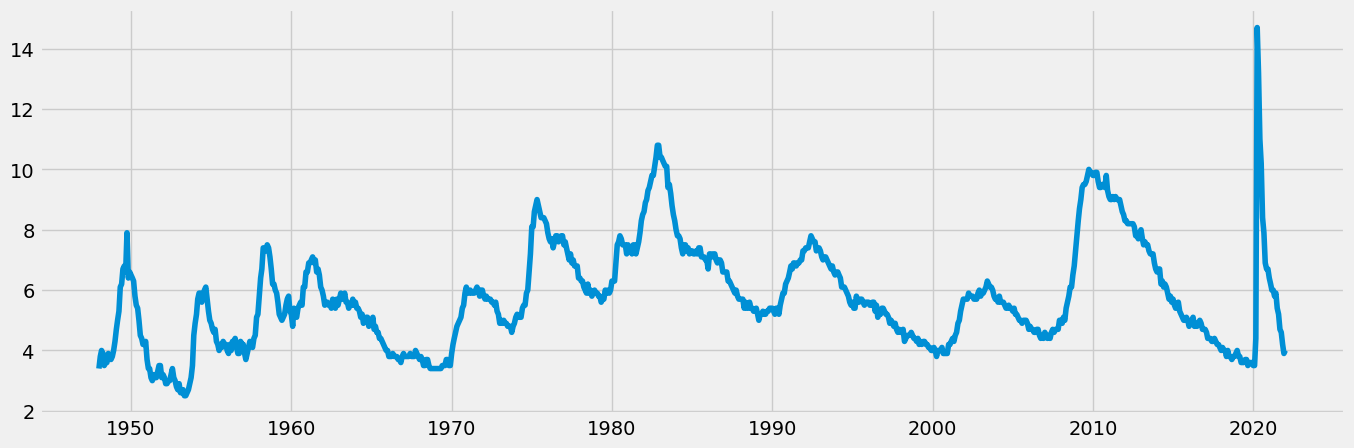

In [44]:
# Plot the data using matplotlib.

plt.figure(figsize=(15,5), dpi=100) # The dpi argument controls the quality of the visualization here. When it's set to 100,
# it will produce lower-than-standard quality, which is useful if, similar to this notebook, you'll have a lot of plots.
# A large number of plots will increase the size of the notebook, which could take more time to load and eat up a lot of RAM!

plt.plot(data2)

The data appears to be non-stationary. 

In [45]:
data_2 = data2.reset_index()

In [46]:
data_2.head

<bound method NDFrame.head of           Date  Value
0   1948-01-01    3.4
1   1948-02-01    3.8
2   1948-03-01    4.0
3   1948-04-01    3.9
4   1948-05-01    3.5
..         ...    ...
884 2021-09-01    4.7
885 2021-10-01    4.6
886 2021-11-01    4.2
887 2021-12-01    3.9
888 2022-01-01    4.0

[889 rows x 2 columns]>

<div id = "clean"></div>

### Data Wrangling, Subsetting, & Cleaning:  Time Series Analysis

In [47]:
data_sub = data_2.loc[(data_2['Date'] >= '1980-01-01') & (data_2['Date'] < '2020-06-01')]

In [48]:
data_sub.shape

(485, 2)

In [49]:
data_sub.head()

,Date,Value
384,1980-01-01,6.3
385,1980-02-01,6.3
386,1980-03-01,6.3
387,1980-04-01,6.9
388,1980-05-01,7.5


In [50]:
# Set the "Date" column as the index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # Create a datetime column from "Date.""
data_sub = data_sub.set_index('datetime') # Set the datetime as the index of the dataframe.
data_sub.drop(['Date'], axis=1, inplace=True) # Drop the "Date" column.
data_sub.head()

,Value
datetime,
1980-01-01,6.3
1980-02-01,6.3
1980-03-01,6.3
1980-04-01,6.9
1980-05-01,7.5


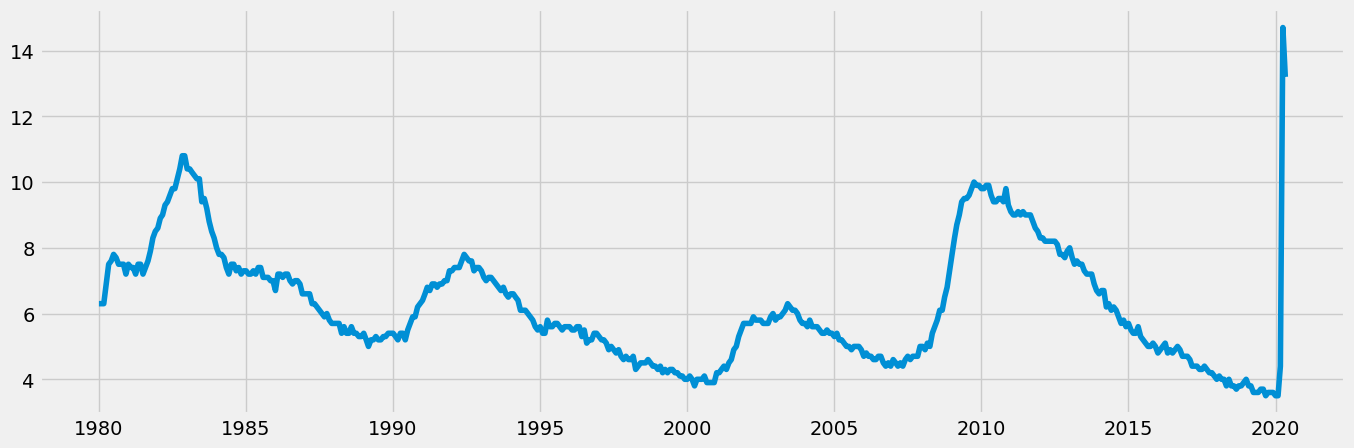

In [51]:
# Plot the data

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_sub)

In [55]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [56]:
from pylab import rcParams # This will define a fixed size for all special charts.

rcParams['figure.figsize'] = 18, 7

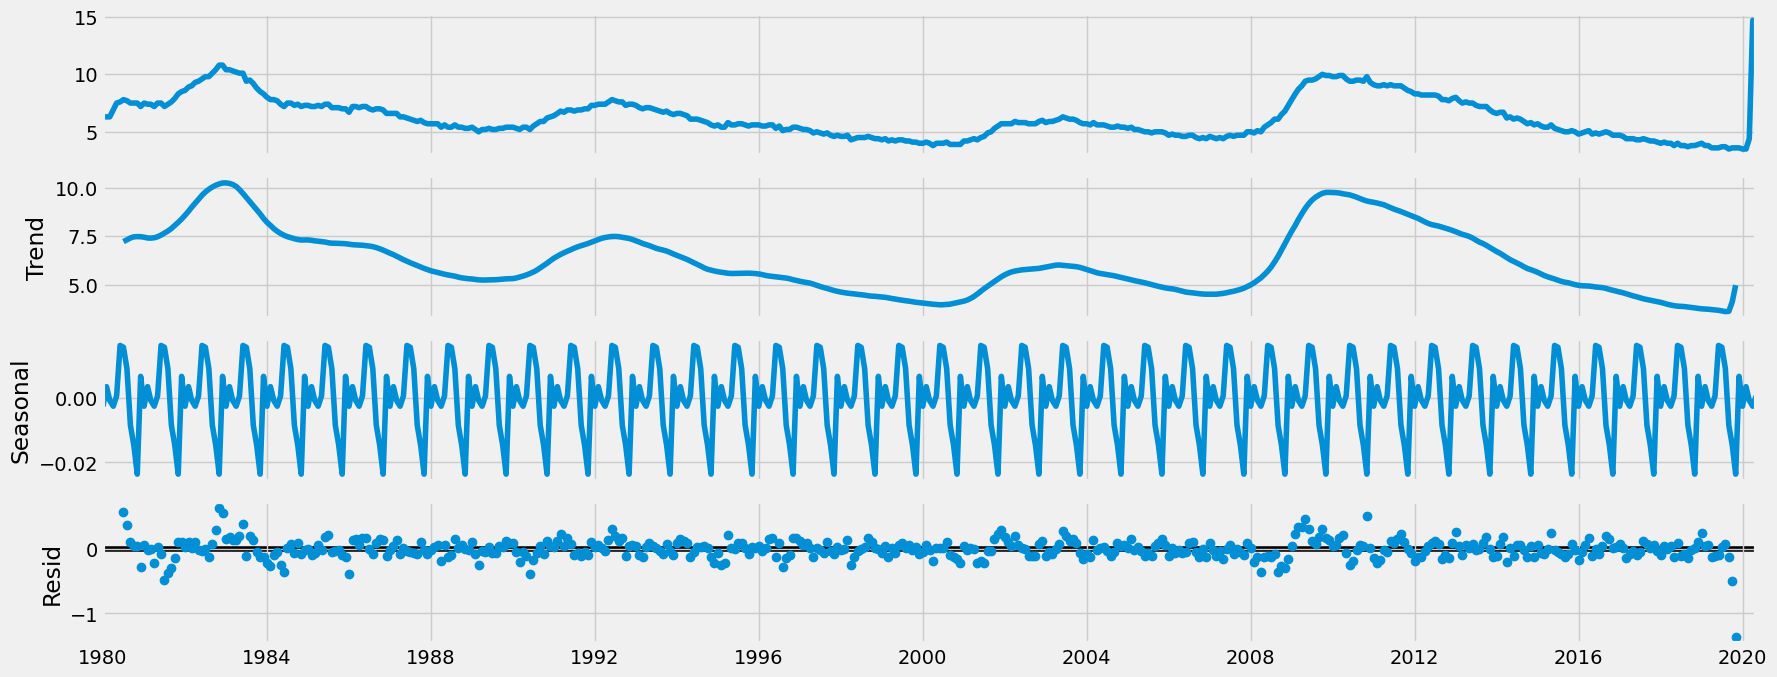

In [57]:
# Plot the separate components

decomposition.plot()
plt.show()

This shows that there is seasonality in the data.  The trend is up in 2008 and declines in 2020. There is a small amout of noise throughout the data. 

<div id = "test"></div>

###  Test for Stationarity

In [58]:
from statsmodels.tsa.stattools import adfuller # Import the adfuller() function

def dickey_fuller(timeseries): # Define the function
    # Perform the Dickey-Fuller test:
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

# Apply the test using the function on the time series
dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                  -2.492172
p-value                          0.117391
Number of Lags Used              6.000000
Number of Observations Used    478.000000
Critical Value (1%)             -3.444105
Critical Value (5%)             -2.867606
Critical Value (10%)            -2.570001
dtype: float64


The Critical Value (5%) at -2.867606 is smaller than the Test Statistic at -2.492172.  Therfore the null hypothesis cannot be rejected and the data is non stationary, as we saw above in the plot.  

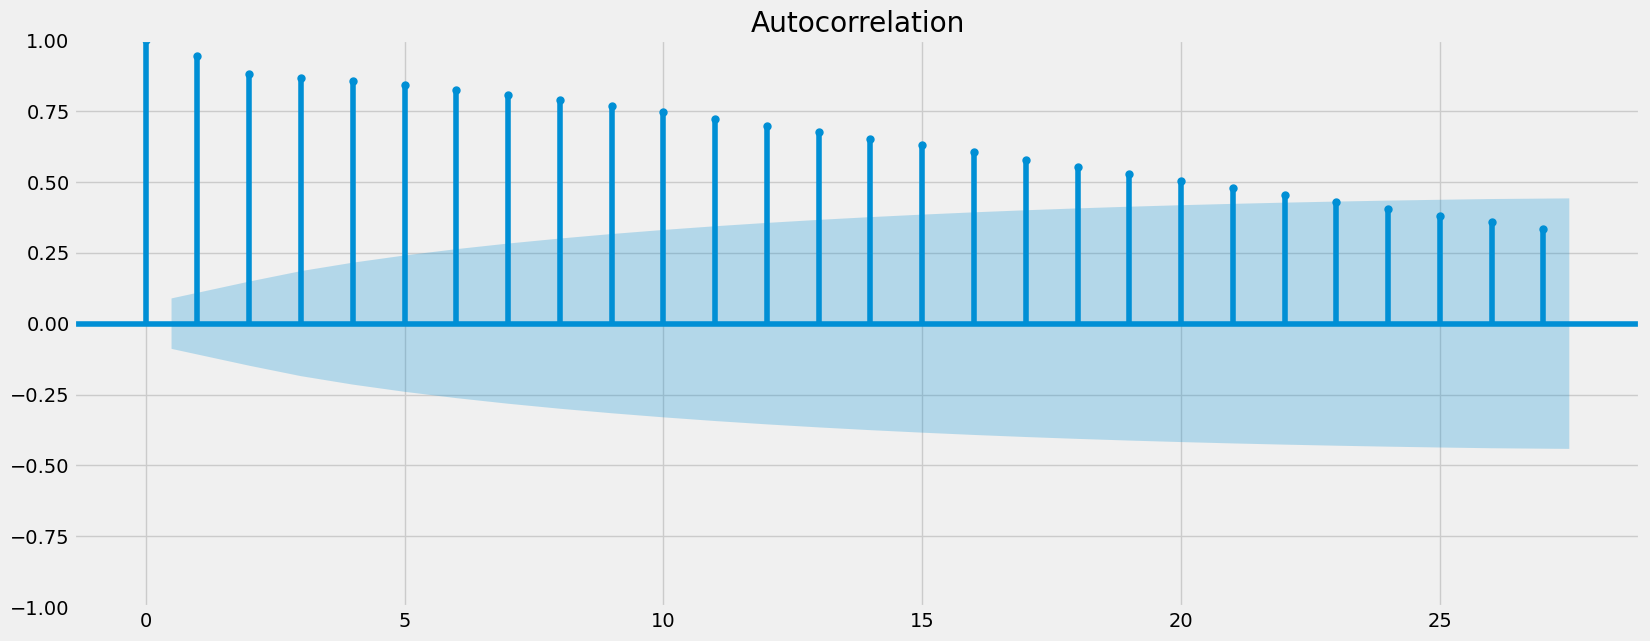

In [59]:
#Plot of Autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_sub)
plt.show()

There are many lines above the blue edges of the confidence interval.  These lags are 
significantly correlated with each other.  Many lags means the data is non stationary. 

<div id = "fed"></div>

### 5. Stationarizing:  Federal Reserve Economic Data

In [60]:
data_diff = data_sub - data_sub.shift(1) 

In [61]:
# Remove missing values from differencing, in order to run the Dicker Fuller Test.
data_diff.dropna(inplace = True)

In [63]:
data_diff.head()

,Value
datetime,
1980-02-01,0.0
1980-03-01,0.0
1980-04-01,0.6
1980-05-01,0.6
1980-06-01,0.1


In [64]:
data_diff.columns

Index(['Value'], dtype='object')

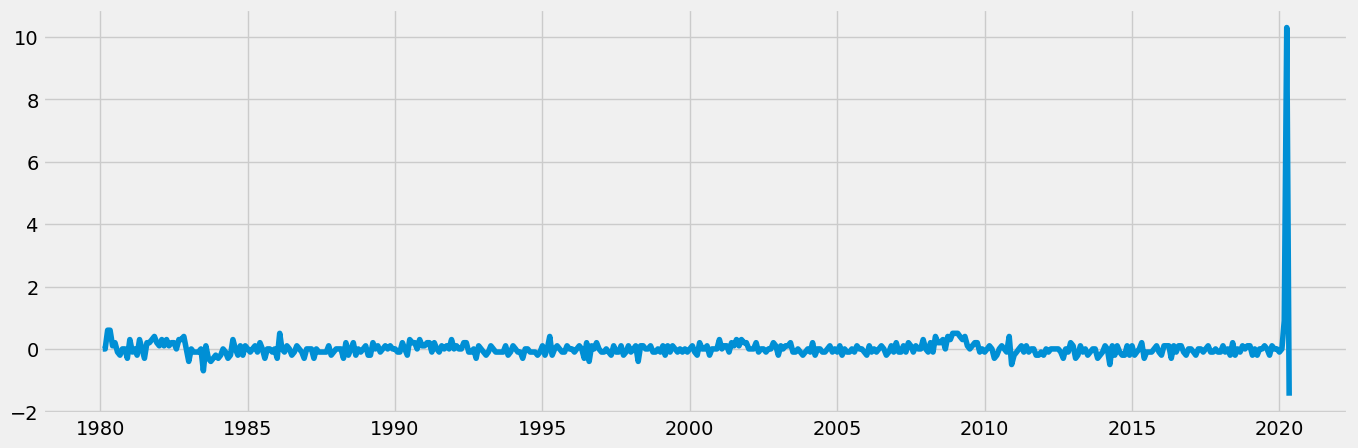

In [65]:
#  Observe what diffencing did to the time curve.
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [66]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -22.532591
p-value                          0.000000
Number of Lags Used              0.000000
Number of Observations Used    483.000000
Critical Value (1%)             -3.443962
Critical Value (5%)             -2.867543
Critical Value (10%)            -2.569967
dtype: float64


The Critical Value (5%) at -2.867543 is much larger than the Test Statistic at -22.532591. Therfore, the null hypothesis can be rejected and the data is stationary.

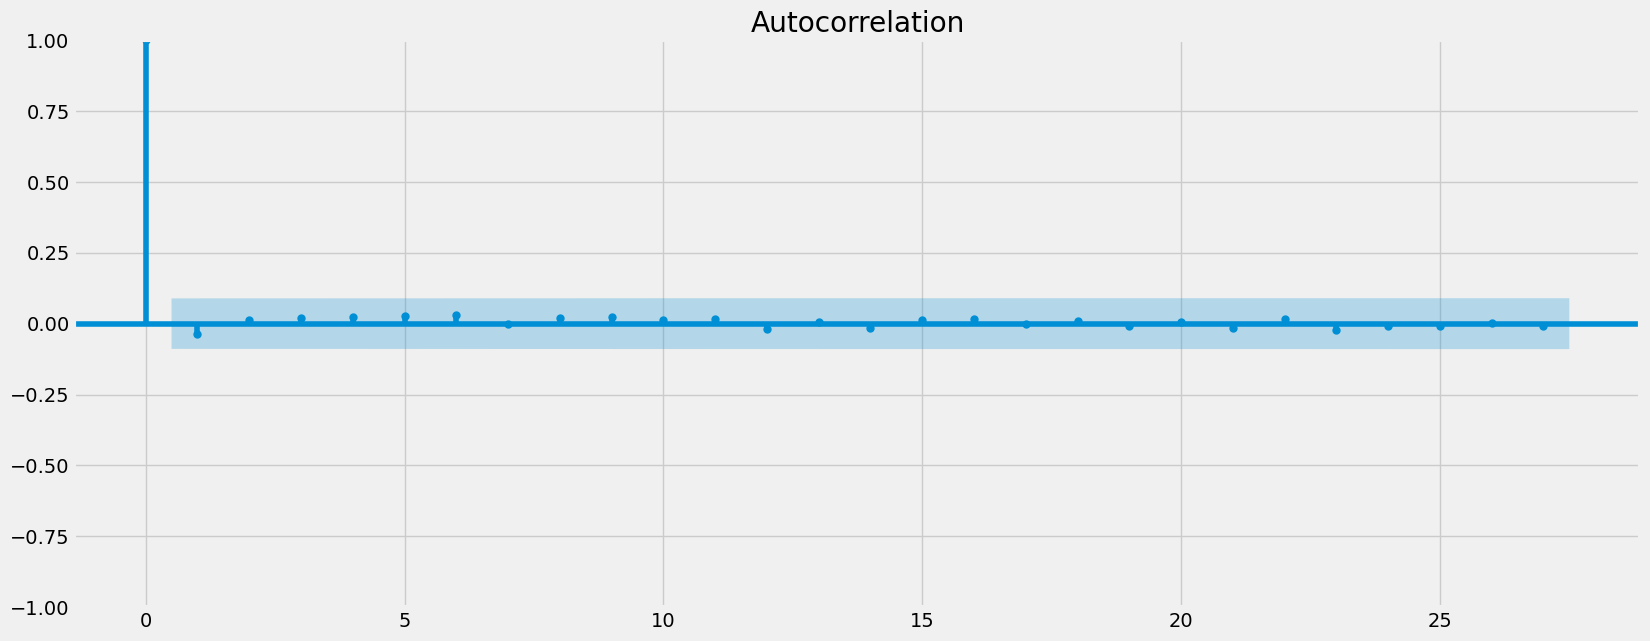

In [67]:
plot_acf(data_diff)
plt.show()

There are no lines above the blue edges of the confidence interval. There are no lags and are not significantly correlated with each other.  The lack of lags means the data is stationary.